In [ ]:
from shared.preface import *
import shared.functions as fct
import shared.my_units as my
import shared.control_center as CC

Max: 1.0087141666305806 Mean: 1.0086749584914274
Max: 1.0833599279757797 Mean: 1.0770752783503539
Max: 1.3685256485139512 Mean: 1.30253066681061
Max: 5.198273943484064 Mean: 3.607173472788007


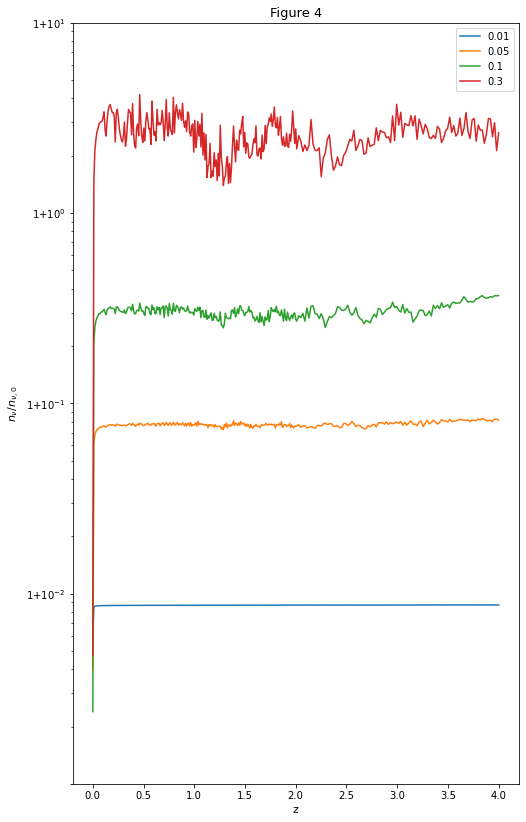

In [1]:
from shared.preface import *
import shared.functions as fct
import shared.my_units as my
import shared.control_center as CC

# Load data, which function uses.
u_all = fct.load_u_sim()

def n_nu_of_redshift(m_eV):
    
    # Convert to momenta.
    p_all, y_all = fct.u_to_p_eV(u_all, m_eV)

    # Select correct momentum range.
    indices = np.where((CC.LOWER <= y_all[:,0]) & (y_all[:,0] <= CC.UPPER))
    p = p_all[indices]

    zeds = CC.ZEDS

    n_nus = np.zeros(len(zeds))
    for i, _ in enumerate(zeds):

        # Calculate number density.
        n_nus[i] = fct.number_density(p[:,0], p[:,i]).value

    np.save(f'neutrino_data/number_densities_at_z_{m_eV.value}eV.npy', n_nus)


# Plotting.
fig, ax = plt.subplots(1,1, figsize=(8,14))

masses = np.array([0.01, 0.05, 0.1, 0.3])*unit.eV
for j, m in enumerate(masses):
    n_nu_of_redshift(m)

    n = np.load(f'neutrino_data/number_densities_at_z_{m.value}eV.npy')/CC.N0
    print('Max:', np.max(n),'Mean:', np.mean(n))

    ax.semilogy(CC.ZEDS, n-1, label=f'{m.value}')

ax.set_title('Figure 4')
ax.set_xlabel('z')
ax.set_ylabel(r'$n_{\nu} / n_{\nu, 0}$')
ax.set_ylim(1e-3, 1e1)
ax.legend()

ax.yaxis.set_major_formatter(ticker.FuncFormatter(fct.y_fmt))
plt.savefig('check_plots/figure_4.pdf')
plt.show()

## Integrand for number density, momentum distr.

In [ ]:
# Load velocities of sim.
u_all = fct.load_u_sim()

# Position of earth w.r.t Milky Way NFW halo center.
x1, x2, x3 = 8.5, 0., 0.
x0 = np.array([x1, x2, x3])

def momentum_shape(m_eV):

    # Convert to momenta.
    p_all, y_all = fct.u_to_p_eV(u_all, m_eV)

    # Select correct momentum range.
    indices = np.where((CC.LOWER <= y_all[:,0]) & (y_all[:,0] <= CC.UPPER))
    p = p_all[indices]
    y = y_all[indices]

    p0, p1, y0 = p[:,0], p[:,-1], y[:,0]

    # Sort.
    order = p0.argsort()
    p0_sort, p1_sort = p0[order], p1[order]

    # Fermi-Dirac values with momentum at end of sim.
    FDvals = fct.Fermi_Dirac(p1_sort)

    FDvals0 = fct.Fermi_Dirac(p0_sort)

    return p0_sort.value, FDvals, y0[order], FDvals0


fig, axs = plt.subplots(2,2, figsize=(12,10))
fig.suptitle(
    'Integrand for number density (np.trapz)' 
    '\n'
    f'{CC.NR_OF_NEUTRINOS} neutrinos',
    fontsize=18)

masses = np.array([0.01, 0.05, 0.1, 0.3])*unit.eV
for j, m in enumerate(masses):
    p0_sort, FDvals, y0, FDvals0 = momentum_shape(m)
    y = p0_sort**2. * FDvals
    y_p0 = p0_sort**2. * FDvals0
    print(y0[0], y0[-1])

    i = 0
    if j in (2,3):
        i = 1
        j -= 2

    yOG = np.linspace(CC.LOWER, CC.UPPER, len(y0))

    axs[i,j].semilogy(y0, y)
    axs[i,j].semilogy(y0, y_p0)
    axs[i,j].set_title(f'{m.value} eV')
    axs[i,j].set_xlabel(r'Initial Momenta (magnitudes) / $T_{\nu ,0}$')
    axs[i,j].set_ylabel(r'$p^2 \cdot$ FD(p)')

    # Escape momenta.
    _, y_esc = fct.escape_momentum(x0, 0., my.rho0_NFW, my.Mvir_NFW, m)
    axs[i,j].axvline(y_esc, c='r', ls='-.')

    # axs[i,j].set_xlim(0,10)
    axs[i,j].set_ylim(y[0],np.max(y))


plt.savefig('check_plots/figure_4_momenta.pdf')
plt.show()